# Example of reproducible analysis pipeline

We are going to reproduce a couple of figures (2A and 8A) of the following paper:

In [1]:
from IPython.display import IFrame
url = "http://www.ncbi.nlm.nih.gov/pubmed/22219510"
IFrame(url, 800, 400)

I select this paper because:  
* The article is open access  
* The reference organism is yeast (12Mb)  
* The data are freely available  
* I know it very well...  

## Required software:

* [SRA](http://www.ncbi.nlm.nih.gov/Traces/sra/?view=software): The Sequence Read Archive (SRA) stores raw sequencing data from the next generation of sequencing platforms including Roche 454 GS System®, Illumina Genome Analyzer®, Applied Biosystems SOLiD® System, Helicos Heliscope®, Complete Genomics®, and Pacific Biosciences SMRT®. **In the analysis version: 2.3.5-2 was used.**


* [Bowtie](http://bowtie-bio.sourceforge.net/index.shtml): Bowtie is an ultrafast, memory-efficient short read aligner. It aligns short DNA sequences (reads) to the human genome at a rate of over 25 million 35-bp reads per hour. Bowtie indexes the genome with a Burrows-Wheeler index to keep its memory footprint small: typically about 2.2 GB for the human genome (2.9 GB for paired-end). **In the analysis version 1.0.1 was used.**

## Required Python libraries:

This is extracted from the command `pip freeze`. On the right of each library there is the version I have been using in the analysis:  
* ipython==3.1.0  
* numpy==1.9.2  
* matplotlib==1.4.3  
* pandas==0.16.1  
* Cython==0.22 
* weblogo==3.4  
* scipy==0.15.1  

## Import modules

In [2]:
%pylab inline
import pandas as pd
import tarfile
import urllib
import os
import weblogolib
import random
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## Define the paths of the required software

In [3]:
SRA = "bin/fastq-dump"
BOWTIE = "bin"

# PIPELINE

## Download the data

In [4]:
# Download one of the set of raw reads of the paper
sra_url = "ftp://ftp-trace.ncbi.nlm.nih.gov/sra/sra-instant/reads/ByStudy/sra/" + \
            "SRP%2FSRP009%2FSRP009462/SRR384975/SRR384975.sra"
sra_file = "reads/SRR384975.sra"
# Download the yeast genomic sequences. The release used in this analysis is: R64-1-1
yeast_url = "http://downloads.yeastgenome.org/sequence/S288C_reference/" + \
            "genome_releases/S288C_reference_genome_Current_Release.tgz"
yeast_file = "data/yeast_genome.tgz"
genome_file = "data/yeast_genome.fa"
# Download the yeast genomic annotations
features_url = "http://downloads.yeastgenome.org/curation/chromosomal_feature/SGD_features.tab"
features_file = "data/yeast_features.tsv"

In [5]:
# Create the directories "reads" and "data"
folders = ["data", "reads", "index", "sequences", "figures"]
_ = [os.mkdir(folder) for folder in folders if not os.path.isdir(folder)]

In [6]:
%%time

# Download the files and save it into the local directory
for (get_url, get_file) in zip([sra_url, yeast_url, features_url], 
                               [sra_file, yeast_file, features_file]):
    if not os.path.isfile(get_file):
        urllib.request.urlretrieve(get_url, get_file)

CPU times: user 246 µs, sys: 461 µs, total: 707 µs
Wall time: 1.48 ms


In [7]:
!ls

analysis.ipynb           bin                      figures                  reads
analysis_slideshow.ipynb data                     index                    sequences


## Extract the SRA file

In [8]:
!time $SRA $sra_file --outdir reads

Read 7990112 spots for reads/SRR384975.sra
Written 7990112 spots for reads/SRR384975.sra

real	1m4.574s
user	0m57.743s
sys	0m1.949s


## Extract the sequence of the yeast genome

In [9]:
tar = tarfile.open(yeast_file)
tar.getnames()

['S288C_reference_genome_R64-2-1_20150113',
 'S288C_reference_genome_R64-2-1_20150113/rna_coding_R64-2-1_20150113.fasta',
 'S288C_reference_genome_R64-2-1_20150113/NotFeature_R64-2-1_20150113.fasta',
 'S288C_reference_genome_R64-2-1_20150113/orf_coding_all_R64-2-1_20150113.fasta',
 'S288C_reference_genome_R64-2-1_20150113/other_features_genomic_R64-2-1_20150113.fasta',
 'S288C_reference_genome_R64-2-1_20150113/S288C_reference_sequence_R64-2-1_20150113.fsa',
 'S288C_reference_genome_R64-2-1_20150113/gene_association_R64-2-1_20150113.sgd',
 'S288C_reference_genome_R64-2-1_20150113/orf_trans_all_R64-2-1_20150113.fasta',
 'S288C_reference_genome_R64-2-1_20150113/saccharomyces_cerevisiae_R64-2-1_20150113.gff']

The right file to extract is **S288C_reference_sequence_R64-2-1_20150113.fsa**

In [10]:
# Extract the file
tar.extract('S288C_reference_genome_R64-2-1_20150113/S288C_reference_sequence_R64-2-1_20150113.fsa',
            'data')

In [11]:
!ls data/

S288C_reference_genome_R64-2-1_20150113 yeast_genome.fa
yeast_features.tsv                      yeast_genome.tgz


In [12]:
# Rename the reference_sequence file
!mv data/S288C_reference_genome_R64-2-1_20150113/S288C_reference_sequence_R64-2-1_20150113.fsa $genome_file
!rm -r data/S288C_reference_genome_R64-2-1_20150113/
#!rm $yeast_file

In [13]:
!ls data/

yeast_features.tsv yeast_genome.fa    yeast_genome.tgz


## Build a bowtie index

In [14]:
index_name = "index/yeast_genome"
!$BOWTIE/bowtie-build -q $genome_file $index_name

## Trim and align the reads to the yeast genome

The reads should start with the `Ty1 LTR` (Long Terminal Repeat), so I check for its presence. I also get rid of reads with _undefined (N)_ nucleotides. In the alignment step, in order to align only the genomic sequence downstream the insertion site, I trim the first 10bp.

In [15]:
%%time

# Reads should start with the Ty1 LTR ("TATT"). 
# I also discard those reads that have ambiguous nucleotides.
fastq_file = os.path.splitext(sra_file)[0] + ".fastq"
trimmed_file = os.path.splitext(sra_file)[0] + ".trimmed"

LTR = "TATT"
MAX_MISMATCHES = 0


class ReadFastq:
    def load(self, line):
        self.lines = [line]
        self.output = ""
    
    def add_line(self, line):
        self.lines.append(line)        
        
    def get_output(self):
        if self.lines[1].startswith(LTR) and self.lines[1].count("N") <= MAX_MISMATCHES:
            self.output = "".join(self.lines)
            return self.output
        else:
            return False
  

with open(fastq_file, 'r') as fi, open(trimmed_file, 'w') as fo:
    parser = ReadFastq()
    for n, line in enumerate(fi):
        if n % 4 == 0:
            if n != 0 and parser.get_output():
                fo.write(parser.get_output())
            parser.load(line)
        else:
            parser.add_line(line)

CPU times: user 1min 7s, sys: 4.04 s, total: 1min 11s
Wall time: 1min 13s


In [16]:
# I align the reads to the yeast genome with Bowtie
# I trim the first 10bp of the reads and then I require 
# unique (-m 1) and perfect (-v 0) alignments.
mapped_file = os.path.splitext(sra_file)[0] + ".mapped"
!$BOWTIE/bowtie -t $index_name -m 1 -v 0 -5 10 -p 2 -q $trimmed_file $mapped_file

Time loading forward index: 00:00:00
Time for 0-mismatch search: 00:00:28
# reads processed: 7504175
# reads with at least one reported alignment: 1187781 (15.83%)
# reads that failed to align: 5885730 (78.43%)
# reads with alignments suppressed due to -m: 430664 (5.74%)
Reported 1187781 alignments to 1 output stream(s)
Time searching: 00:00:28
Overall time: 00:00:28


## Get rid of potential clonal reads

In [17]:
unique_file = mapped_file + ".unique"
%timeit -n 1 -r 1 !cut -f2-5 $mapped_file | sort -u > $unique_file

1 loops, best of 1: 53.8 s per loop


In [18]:
!head $unique_file

+	ref|NC_001133|	101400	GCATTATCTATCATTATAAATTCTTTTATT
+	ref|NC_001133|	11050	TAAAGTCACTGAGATATTAGAGGTTATAAA
+	ref|NC_001133|	11333	AAACTCTATGTAAACACTTATTTTATTGTG
+	ref|NC_001133|	115808	CCTCTCAGATACCACGATGCATAAGGCTCA
+	ref|NC_001133|	118483	ATATGTGTATATATACATAGGTTAGTATGT
+	ref|NC_001133|	118488	TGTATATATACATAGGTTAGTATGTATAGC
+	ref|NC_001133|	125037	AGGGTAGAAGCCATGAAAAAACTAGATACC
+	ref|NC_001133|	125957	GATCTTACCTGCTGTGCAGAATTTGAGTAT
+	ref|NC_001133|	127779	GATCTCAGTACTCGCATTCTAGCGTATGTT
+	ref|NC_001133|	1289	ATTTCTAGTTACAGTTACACAAAAAACTAT


## Extract the regions upstream and downstream the Ty1 insertion sites

In [19]:
# Load the yeast genome in memory
dict_genome = {}
sequence = ""

with open(genome_file, 'r') as fi:
    for line in fi:
        if line.startswith(">"):
            if sequence != "":
                dict_genome[head] = sequence.upper()
            head = line.split()[0][1:]
            sequence = ""
            continue
        sequence += line.strip()
    if sequence != "":
        dict_genome[head] = sequence.upper()

In [20]:
# Define a class to read the alignment file
class ParseAlignments:
    def read(self, line):
        self.line = line.strip().split("\t")
        self.strand = self.line[0]
        self.chromosome = self.line[1]
        self.position = int(self.line[2])

In [21]:
# Define a function to extract the genomic sequences
# upstream and downstream a given position.
def reverse_complement(sequence):
    d = {"A":"T", "T":"A", "C":"G", "G":"C", "N":"N"}
    sequence = sequence[::-1]
    return "".join([d[i] for i in sequence])
    
def get_sequences(input_file, output_file, window=10):
    with open(input_file, 'r') as fi, open(output_file, 'w') as fo:
        parser = ParseAlignments()
        for n, line in enumerate(fi):
            parser.read(line)
            if parser.strand == "+":
                position = parser.position + 3
            else:
                position = parser.position - 3
            sequence = dict_genome[parser.chromosome][position - window: position + window]
            if parser.strand == "-":
                sequence = reverse_complement(sequence)
            fo.write(">sequence_{}\n{}\n".format(n, sequence))

In [22]:
# Extract sequences of 10bp and 1Kb
get_sequences(input_file=unique_file, output_file="sequences/fasta_10bp.fa")
get_sequences(input_file=unique_file, output_file="sequences/fasta_1kb.fa", window=1000)

## Seqlogos

First we will check the presence of the insertion site pattern. We will do a seqlogo of the flanking regions of the Ty1 insertion sites.

In [23]:
def do_seqlogo(input_fasta, output_seqlogo):
    fin = open(input_fasta)
    seqs = weblogolib.read_seq_data(fin) 
    data = weblogolib.LogoData.from_seqs(seqs)
    options = weblogolib.LogoOptions()
    options.yaxis_scale = 0.2
    options.yaxis_tic_interval  = 0.2
    format_logo = weblogolib.LogoFormat(data, options)
    fout = weblogolib.eps_formatter(data, format_logo)
    with open(output_seqlogo, 'wb') as fo:
        fo.write(fout)

In [24]:
# Create the seqlogos
do_seqlogo("sequences/fasta_10bp.fa", "figures/fasta_10bp.eps")

<img src="figures/fasta_10bp.png">

To verify that the above seqlogo is meaninful, we can compare it with a seqlogo obtained with 10000 random sequences.

In [25]:
# Select 10000 random position in the yeast genome
N = 10000
genome_length = sum([len(i) for i in dict_genome.values()])
sample = random.sample(range(1, genome_length + 1), N)

# This function map a random number to a chromosome and position in the yeast genome
def get_coordinates(number):
    for chromosome, sequence in dict_genome.items():
        if (number - len(sequence)) > 0:
            number -= len(sequence)
        # Do not consider position that are too close to the start/end of the chromosome
        elif number < 10 or number > len(sequence) - 10:
            continue
        else:
            return (chromosome, number)
  
# Open the output file
random_file = "reads/random.mapped"

with open(random_file, "w") as fo:
    for n in sample:
        chromosome, position = get_coordinates(n) 
        fo.write("+\t{}\t{}\n".format(chromosome, position))

In [26]:
# Extract sequences of 10bp and 1Kb
get_sequences(input_file=random_file, output_file="sequences/random_10bp.fa")

# Create the seqlogos
do_seqlogo("sequences/random_10bp.fa", "figures/random_10bp.eps")

<img src="figures/random_10bp.png">

## Ty1 insertions around tRNAs

Second, we will verify that the Ty1 retrotransposons have a strong preference for inserting upstream tRNA genes.  
First of all lets look at the structure of the features file.

In [27]:
# Create a dataframe with the yeast features
df = pd.read_csv(features_file, sep="\t", header=None)

In [28]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,S000028864,telomeric_repeat,NaN,TEL01L-TR,NaN,NaN,chromosome 1,NaN,1,62,1,C,NaN,2003-09-09,2003-09-09,Terminal telomeric repeats on the left arm of ...
1,S000002143,ORF,Dubious,YAL069W,NaN,NaN,chromosome 1,NaN,1,335,649,W,NaN,1996-07-31,1996-07-31,Dubious open reading frame; unlikely to encode...
2,S000031098,CDS,NaN,NaN,NaN,NaN,YAL069W,NaN,1,335,649,W,NaN,1996-07-31,1996-07-31,NaN


The **feature** column is the second. Lets look at which features are in the file

In [29]:
np.unique(df[1])

array(['ARS', 'ARS consensus sequence', 'CDEI', 'CDEII', 'CDEIII', 'CDS',
       'ORF', 'W_region', 'X_element_combinatorial_repeats',
       'X_element_core_sequence', 'X_region', "Y'_element", 'Y_region',
       'Z1_region', 'Z2_region', 'binding_site', 'centromere',
       'external_transcribed_spacer_region', 'five_prime_UTR_intron',
       'gene_cassette', 'insertion', 'internal_transcribed_spacer_region',
       'intron', 'long_terminal_repeat', 'mating_locus', 'multigene locus',
       'ncRNA', 'non_transcribed_region', 'noncoding_exon',
       'not in systematic sequence of S288C', 'not physically mapped',
       'plus_1_translational_frameshift', 'pseudogene', 'rRNA',
       'repeat_region', 'retrotransposon', 'snRNA', 'snoRNA', 'tRNA',
       'telomere', 'telomeric_repeat', 'transposable_element_gene'], dtype=object)

We will extract the the rows that contain the **tRNA** feature

In [30]:
df_trna = df[df[1] == "tRNA"].copy()
trna = pd.DataFrame({"Chromosome": df_trna[8], 
                     "Start": df_trna[9], 
                     "End": df_trna[10], 
                     "Strand": df_trna[11]})

The chromosomes in the features file are named from 1 to 17 but the mapped file have different names.   
Here we create a dictionary that convert one format into the other.

In [31]:
dict_chromosomes = {"NC_001133": "1", "NC_001134": "2", "NC_001135": "3", 
                    "NC_001136": "4", "NC_001137": "5", "NC_001138": "6", 
                    "NC_001139": "7", "NC_001140": "8", "NC_001141": "9", 
                    "NC_001142": "10", "NC_001143": "11", "NC_001144": "12", 
                    "NC_001145": "13", "NC_001146": "14", "NC_001147": "15", 
                    "NC_001148": "16", "NC_001224": "17"}

Lets look at the first lines of the dataframe:

In [32]:
trna.head()

,Chromosome,End,Start,Strand
176,1,139254,139152,W
222,1,166339,166267,W
239,1,181254,181141,W
243,1,182522,182603,C
376,10,59100,59172,C


The strand column uses **W (Whatson)** and **C (Crick)** to indicate the positive and the negative strands.  
Lets use **+** and **-** instead.

In [33]:
trna['Strand'] = trna['Strand'].apply(lambda x: "+" if x == "W" else "-")

In [34]:
# Look at the first lines of the dataframe
trna.head()

,Chromosome,End,Start,Strand
176,1,139254,139152,+
222,1,166339,166267,+
239,1,181254,181141,+
243,1,182522,182603,-
376,10,59100,59172,-


Now we create a dataframe with the **Ty1** insertion positions.

In [35]:
insertions = []
with open(unique_file, 'r') as fi:
    parser = ParseAlignments()
    for line in fi:
        parser.read(line)
        chromosome = dict_chromosomes[parser.chromosome.split("|")[1]]
        insertions.append([chromosome, parser.position, parser.strand])
    
# We create a dataframe with the Ty1 insertion positions.
insertions = pd.DataFrame(insertions, columns=["Chromosome", "Position", "Strand"])

In [36]:
# Look at the first lines of the dataframe
insertions.head()

,Chromosome,Position,Strand
0,1,101400,+
1,1,11050,+
2,1,11333,+
3,1,115808,+
4,1,118483,+


We calculate the distances of the insertions 1Kb upstream and downstream tRNA genes.

In [37]:
def calculate_distances(feature, insertions, window=1000):
    feature_grouped = feature.groupby(["Chromosome"])
    insertions_grouped = insertions.groupby(["Chromosome"])
    insertions_chromosomes = np.unique(insertions['Chromosome'])

    distances_from_feature = []
    
    for chromosome, feature_group in feature_grouped:
        if chromosome not in insertions_chromosomes:
            continue
        insertions_group = insertions_grouped.get_group(chromosome)
        
        for n, line in feature_group.iterrows():
            start, end, strand = line[1:]
            insertions_around = insertions_group[(insertions_group['Position'] >= start - window) &
                                                 (insertions_group['Position'] <= start + window)]
            if len(insertions_around) == 0:
                continue
                
            # Calculate the distance of the insertions from the feature
            distances = insertions_around['Position'].apply(lambda x: x - start)
            
            # Correct for the strand of the feature
            distances = distances.apply(lambda x: x * -1 if strand == "-" else x)
            distances_from_feature.extend(distances)
    return distances_from_feature

In [38]:
distances = calculate_distances(trna, insertions)

Represent with a histogram the distribution of the Ty1 insertions aroung tRNA TSS 

In [39]:
sns.set_context('poster')
def plot_distances(distances):
    fig = sns.distplot(distances)
    fig.set_xlim((-1000, 1000))
    fig.set_xlabel("Distance from tRNA TSS")
    fig.plot([0, 0], [0, fig.axis()[3]], 'k--', lw=2, alpha=0.5)

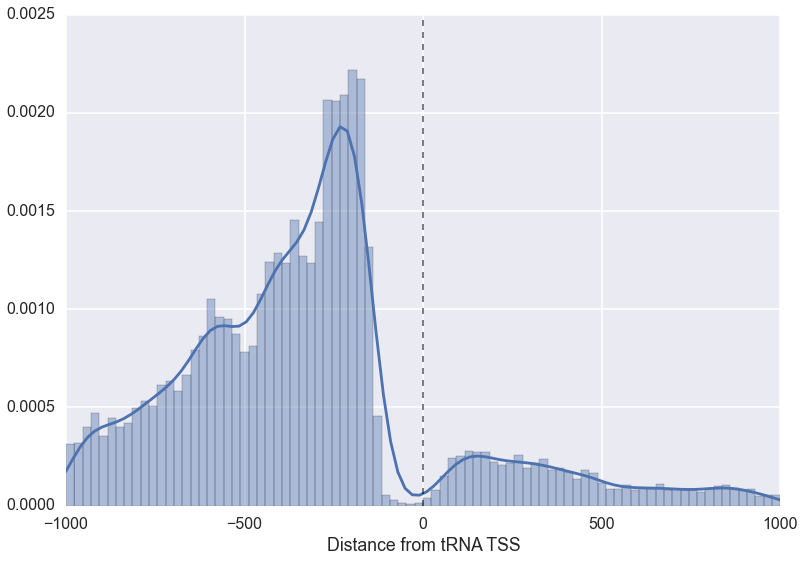

In [40]:
plot_distances(distances)

We got a peak of insertions just upstream the tRNA TSS, as expected. This is the position where 
the nucleosome is located.  
Also notice that there are other two smaller peaks that overlap with the positions of other nucleosomes.

Now we can check if this happens with every TSS. So first we extract the rows of the features file
that contain the **ORF** feature and are **not marked as Dubious**.

In [41]:
df_orf = df[(df[1] == "ORF") & (df[2] != "Dubious")]
orf = pd.DataFrame({"Chromosome": df_orf[8], 
                    "Start": df_orf[9], 
                    "End": df_orf[10], 
                    "Strand": df_orf[11]})
orf['Strand'] = orf['Strand'].apply(lambda x: "+" if x == "W" else "-")

In [42]:
# Look at the first lines of the dataframe
orf.head()

,Chromosome,End,Start,Strand
11,1,1807,2169,-
13,1,2707,2480,+
16,1,7235,9016,-
20,1,11565,11951,-
22,1,12426,12046,+


Calculate the distances of the insertions from the ORF TSS

In [43]:
distances = calculate_distances(orf, insertions)

Represent with a histogram the distribution of the Ty1 insertions aroung ORF TSS.  

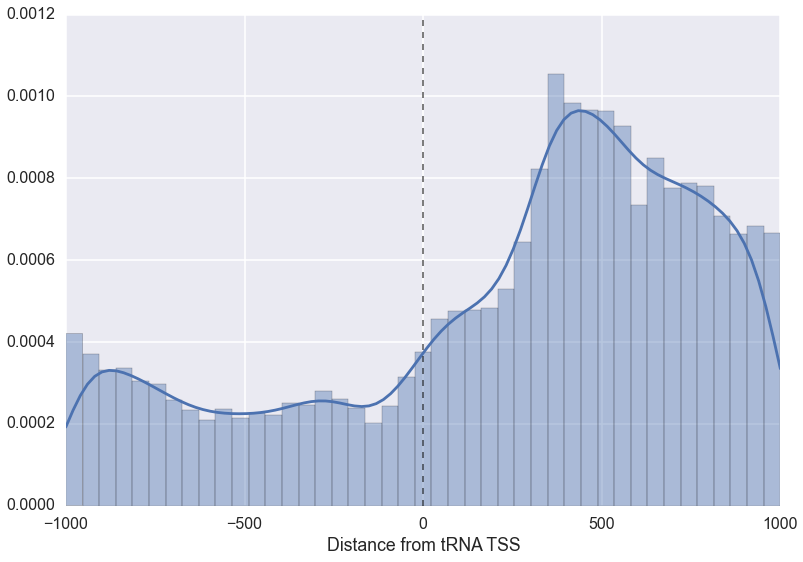

In [44]:
plot_distances(distances)